In [1]:
import ROOT
import uproot
import math
import psutil,time
from tqdm import tqdm
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import pickle
import os
import gc
import glob,random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
Threshold_i=0.1
Si=0.75  # mm
CellSize=5.0  # mm
SamplingLayer=30
ECAL_layers=120
Cluster_Size=16
CONF_NAME=f"DGCNN_ClusterSize{Cluster_Size}_WD1e-12"
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
with open(f'{DataPath_Validate}/Hist/{CONF_NAME}.pkl', 'rb') as f:
    Data = pickle.load(f)
y_val_true = Data["y_val_true"]
y_val_pred = Data["y_val_pred"]
y_test_true = Data["y_test_true"]
y_test_pred = Data["y_test_pred"]
if "best_val_loss" in Data:
    best_val_loss = Data["best_val_loss"]
else:
    best_val_loss = -1

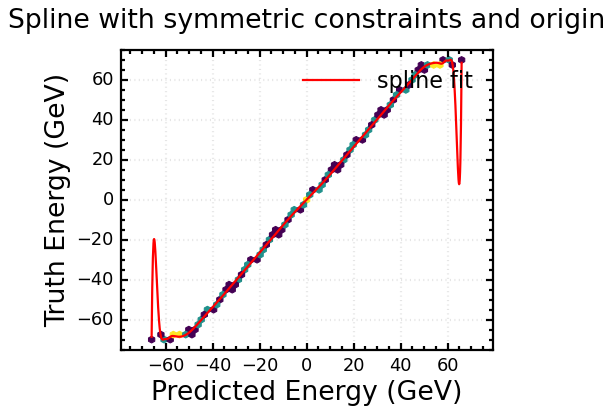

In [2]:
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = ( np.isclose(y_truth, E_truth) )
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist
def plot_NHit_vs_Etruth_spline(N, E_truth,s_factor=0):

    N = np.array(N).flatten()
    E_truth = np.array(E_truth).flatten()

    # sort
    sort_idx = np.argsort(N)
    N_sorted = N[sort_idx]
    E_sorted = E_truth[sort_idx]

    bin_edges = np.arange(-0.5, N_sorted.max() + 1.5, 1)
    bin_centers = np.arange(0, N_sorted.max() + 1, 1)

    E_bin_mean = np.array([
        E_sorted[(N_sorted >= bin_edges[i]) & (N_sorted < bin_edges[i+1])].mean()
        if np.any((N_sorted >= bin_edges[i]) & (N_sorted < bin_edges[i+1])) else np.nan
        for i in range(len(bin_centers))
    ])

    valid = ~np.isnan(E_bin_mean)
    x_fit = bin_centers[valid]
    y_fit = E_bin_mean[valid]
    x_sym = -x_fit
    y_sym = -y_fit
    x_full = np.concatenate((x_sym,[0],x_fit))
    y_full = np.concatenate((y_sym,[0],y_fit))
    sort_idx = np.argsort(x_full)
    x_full = x_full[sort_idx]
    y_full = y_full[sort_idx]

    # spline 拟合
    spline = UnivariateSpline(x_full, y_full, s=s_factor, k=5)

    # 绘图
    N_fine = np.linspace(x_full.min(), x_full.max(), 1000)
    E_smooth = spline(N_fine)

    plt.figure(figsize=(6,5))
    plt.hexbin(x_full, y_full, gridsize=50, cmap='viridis', mincnt=1)
    plt.plot(N_fine, E_smooth, 'r-', lw=2, label='spline fit')
    plt.xlabel("Predicted Energy (GeV)")
    plt.ylabel("Truth Energy (GeV)")
    plt.ylim(-75, 75)
    plt.title("Spline with symmetric constraints and origin")
    plt.grid(True)
    plt.legend()
    plt.show()

    return spline

Calib_spline = plot_NHit_vs_Etruth_spline(y_val_pred, y_val_true, s_factor=1)
y_test_pred_calib = Calib_spline(y_test_pred)
Reco_hist_calib = build_reco_hist(y_test_pred_calib, y_test_true, Energy_test, Nbins=100)

Step 1 Linear fit coeffs: [-0.00094367 -0.29742503]


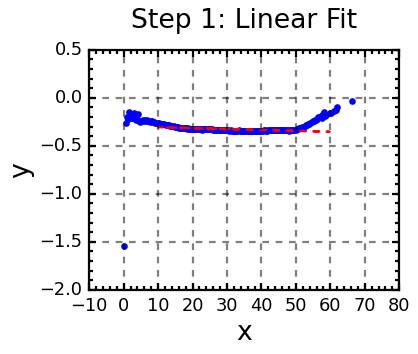

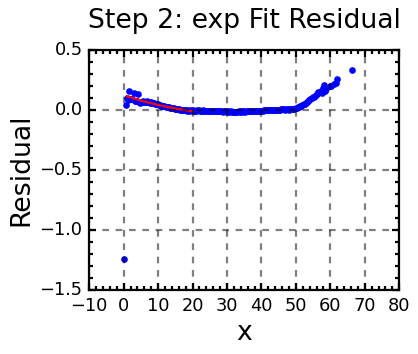

Step 3 Linear fit coeffs: [-0.0009425  -0.29743767]


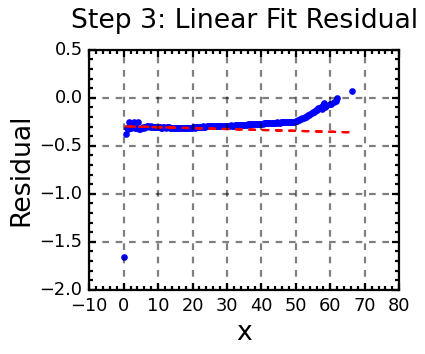

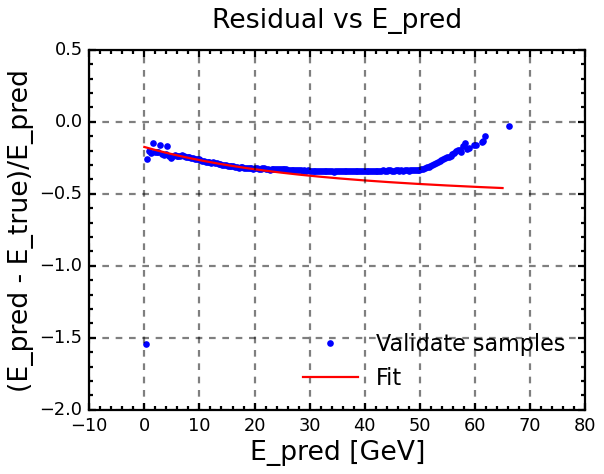

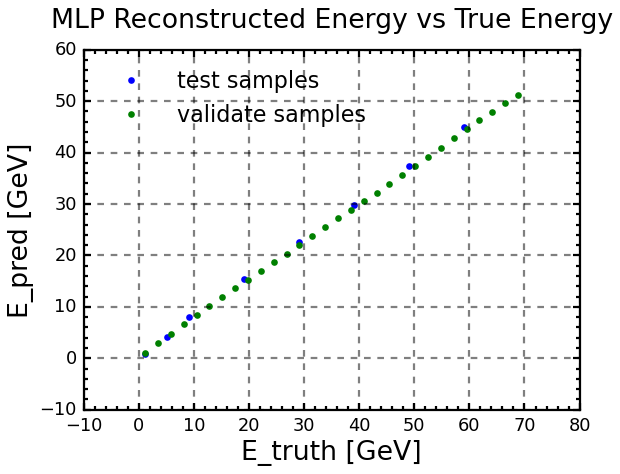

In [3]:
def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (1, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = ( np.isclose(y_truth, E_truth) )
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

Reco_hist = build_reco_hist(y_test_pred, y_test_true, Energy_test, Nbins=50)

fit_range = (0, 65) 
mask = y_val_pred>0
residual_E = (y_val_pred[mask] - y_val_true[mask]) / y_val_pred[mask]
E_calib_fit = Combined_fit(y_val_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_val_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
#plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

# y_val_pred_calib = y_val_pred*(1-E_calib_fit(y_val_pred))
# y_test_pred_calib = y_test_pred*(1-E_calib_fit(y_test_pred))
# Reco_hist_calib = build_reco_hist(y_test_pred_calib, y_test_true, Energy_test, Nbins=100)

plt.figure(figsize=fig_size)
plot_binned(y_test_true, y_test_pred, color="blue", label="test samples")
plot_binned(y_val_true, y_val_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [4]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


Saving fit results to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Reco_Results/RecoE_DGCNN_ClusterSize16_WD1e-12_Fit.csv
Mean: 1.218219186698537, Peak: 0.08940720086793617, RMS: 1.280954443680852
Initial Gamma Fit Parameters: [np.float64(259.58700947230955), np.float64(0.9015533713232544), np.float64(0.0633703894865611), np.float64(1.280954443680852)]
Gamma Fit Bounds: lower [np.float64(2.5958700947230957), np.float64(-0.9098446628676745), np.float64(-0.9936629610513439), np.float64(0.1280954443680852)], 
 upper [np.float64(1557.5220568338573), np.float64(9.015533713232545), np.float64(10.095055584229842), np.float64(12.809544436808519)]
Gamma Fit Parameters: [2.59587803e+02 8.98813983e-01 8.94061269e-02 1.28073876e+00]
Gamma Fit Peak: -0.0401867273178914 ± 0.4384914293574498, Mean: 1.24055203027419 ± 0.5024295724502479, Resolution: -30.21431984337317 ± 316.2370615596713


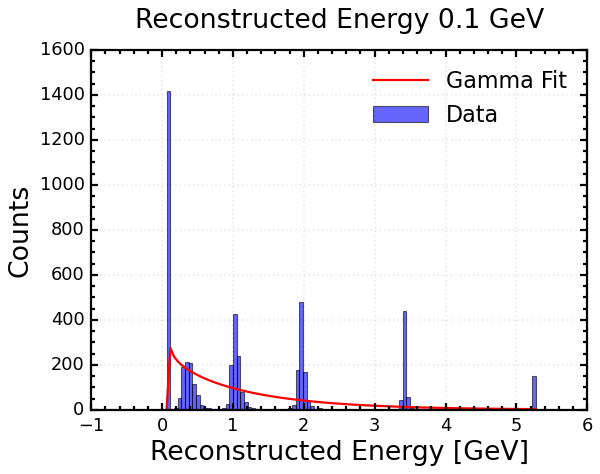

appending results for E = 0.1
Mean_Gamma: 1.24055203027419 Mean_Gamma_Error: 0.5024295724502479
Peak_Gamma: -0.0401867273178914 Peak_Gamma_Error: 0.4384914293574498
Mean: 0.13632010971119257, Peak: 0.08634872108839556, RMS: 0.13314411405224946
Initial Gamma Fit Parameters: [np.float64(58.08386915517258), np.float64(0.5943620891496108), np.float64(0.057184295925123536), np.float64(0.13314411405224946)]
Gamma Fit Bounds: lower [np.float64(0.5808386915517258), np.float64(-0.940563791085039), np.float64(-0.9942815704074877), np.float64(0.013314411405224947)], 
 upper [np.float64(348.5032149310355), np.float64(5.943620891496107), np.float64(10.085776443887685), np.float64(1.3314411405224946)]
Gamma Fit Parameters: [7.78965486e+01 8.60178226e-01 7.46829583e-02 1.33144114e-02]
Gamma Fit Peak: 0.07282131364249887 ± 0.8722448343798006, Mean: 0.08613572504772385 ± 0.8381206773995884, Resolution: 0.16957338342274542 ± 1.5196549571377027


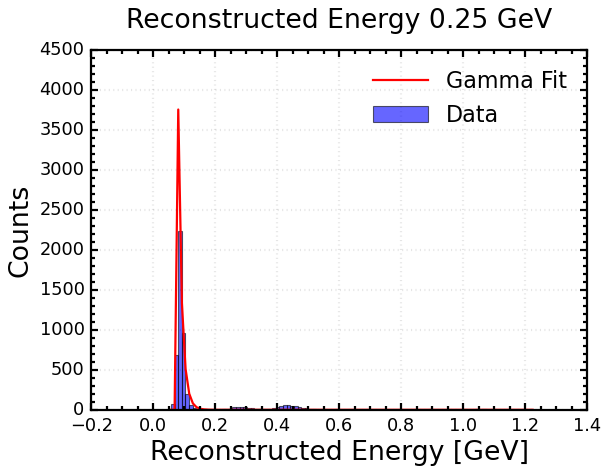

appending results for E = 0.25
Mean_Gamma: 0.08613572504772385 Mean_Gamma_Error: 0.8381206773995884
Peak_Gamma: 0.07282131364249887 Peak_Gamma_Error: 0.8722448343798006
Mean: 0.493610191621339, Peak: 0.4754206800765607, RMS: 0.14340791756238475
Initial Gamma Fit Parameters: [np.float64(58.31201270750027), np.float64(3.0155473102733352), np.float64(0.06115683154418947), np.float64(0.14340791756238475)]
Gamma Fit Bounds: lower [np.float64(0.5831201270750027), np.float64(-0.6984452689726665), np.float64(-0.9938843168455811), np.float64(0.014340791756238475)], 
 upper [np.float64(349.8720762450016), np.float64(30.155473102733353), np.float64(10.091735247316285), np.float64(1.4340791756238476)]
Gamma Fit Parameters: [51.15713962  2.63830225  0.38815064  0.05244084]
Gamma Fit Peak: 0.47406459375878746 ± 0.0032228691665679866, Mean: 0.5265054387079272 ± 0.0039887208650642835, Resolution: 0.17967780523527208 ± 0.009425423928109621


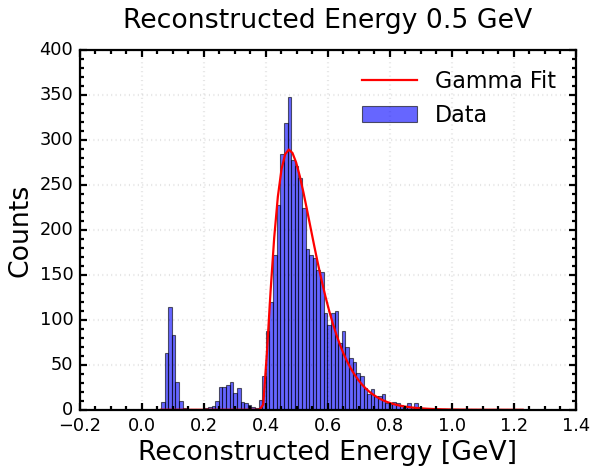

appending results for E = 0.5
Mean_Gamma: 0.5265054387079272 Mean_Gamma_Error: 0.0039887208650642835
Peak_Gamma: 0.47406459375878746 Peak_Gamma_Error: 0.0032228691665679866
Mean: 0.9906365824115527, Peak: 0.9471632170515096, RMS: 0.19872168252478636
Initial Gamma Fit Parameters: [np.float64(93.84929542336279), np.float64(4.6117081727678055), np.float64(0.0741901750058263), np.float64(0.19872168252478636)]
Gamma Fit Bounds: lower [np.float64(0.9384929542336279), np.float64(-0.5388291827232194), np.float64(-0.9925809824994174), np.float64(0.019872168252478638)], 
 upper [np.float64(563.0957725401768), np.float64(46.117081727678055), np.float64(10.111285262508739), np.float64(1.9872168252478637)]
Gamma Fit Parameters: [9.31121916e+01 1.20567421e+01 3.17803556e-01 5.57276156e-02]
Gamma Fit Peak: 0.9339694287524523 ± 0.003003658600503384, Mean: 0.9896970443215032 ± 0.003111414623802099, Resolution: 0.20718236475916516 ± 0.0028804067940454234


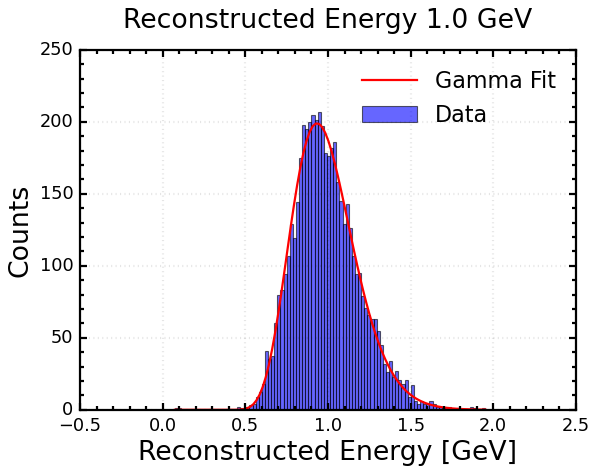

appending results for E = 1.0
Mean_Gamma: 0.9896970443215032 Mean_Gamma_Error: 0.003111414623802099
Peak_Gamma: 0.9339694287524523 Peak_Gamma_Error: 0.003003658600503384
Mean: 2.0495459521456856, Peak: 2.0743800241027155, RMS: 0.27203149212005123
Initial Gamma Fit Parameters: [np.float64(111.92127737425537), np.float64(3.653449392478465), np.float64(1.055692662524674), np.float64(0.27203149212005123)]
Gamma Fit Bounds: lower [np.float64(1.1192127737425537), np.float64(-0.6346550607521535), np.float64(-0.8944307337475326), np.float64(0.027203149212005125)], 
 upper [np.float64(671.5276642455322), np.float64(36.53449392478465), np.float64(11.58353899378701), np.float64(2.7203149212005124)]
Gamma Fit Parameters: [1.09923941e+02 3.65344939e+01 5.14050580e-01 4.21427390e-02]
Gamma Fit Peak: 2.011571484561109 ± 0.004511194666099936, Mean: 2.0537142236078796 ± 0.004561951583570261, Resolution: 0.12663065005703644 ± 0.0016419886118959174


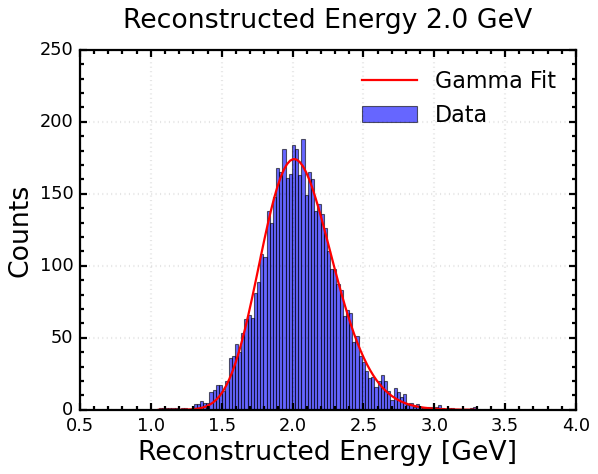

appending results for E = 2.0
Mean_Gamma: 2.0537142236078796 Mean_Gamma_Error: 0.004561951583570261
Peak_Gamma: 2.011571484561109 Peak_Gamma_Error: 0.004511194666099936
Mean: 5.00886247809798, Peak: 4.9838879832985095, RMS: 0.4598988857383018
Initial Gamma Fit Parameters: [np.float64(193.42846151155277), np.float64(4.220636272040599), np.float64(3.067796559479848), np.float64(0.4598988857383018)]
Gamma Fit Bounds: lower [np.float64(1.9342846151155277), np.float64(-0.5779363727959401), np.float64(-0.6932203440520152), np.float64(0.045989888573830184)], 
 upper [np.float64(1160.5707690693166), np.float64(42.20636272040599), np.float64(14.601694839219771), np.float64(4.598988857383018)]
Gamma Fit Parameters: [1.92274729e+02 4.22063627e+01 2.09733675e+00 6.94324220e-02]
Gamma Fit Peak: 4.9583943189130615 ± 0.010352377678031566, Mean: 5.027826740939046 ± 0.010453179774912018, Resolution: 0.0909725183549117 ± 0.0014820902141131774


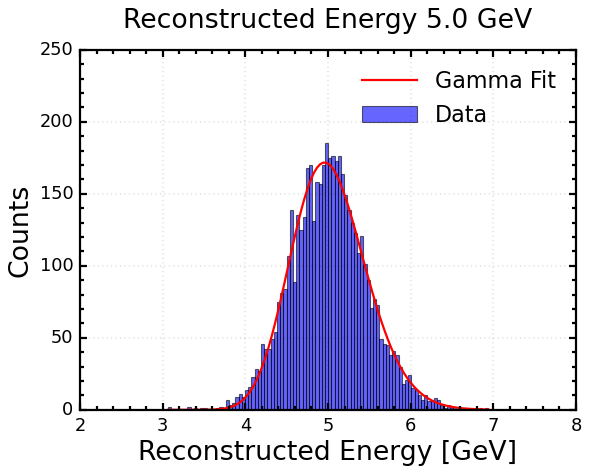

appending results for E = 5.0
Mean_Gamma: 5.027826740939046 Mean_Gamma_Error: 0.010453179774912018
Peak_Gamma: 4.9583943189130615 Peak_Gamma_Error: 0.010352377678031566
Mean: 10.09400178486794, Peak: 10.163445402646165, RMS: 0.690818279387088
Initial Gamma Fit Parameters: [np.float64(275.6104008335718), np.float64(4.17178999319504), np.float64(7.212052999804671), np.float64(0.690818279387088)]
Gamma Fit Bounds: lower [np.float64(2.756104008335718), np.float64(-0.5828210006804959), np.float64(-0.2787947000195329), np.float64(0.0690818279387088)], 
 upper [np.float64(1653.662405001431), np.float64(41.717899931950406), np.float64(20.818079499707007), np.float64(6.908182793870879)]
Gamma Fit Parameters: [2.74152307e+02 4.17178999e+01 5.72850946e+00 1.05495144e-01]
Gamma Fit Peak: 10.024050161343197 ± 0.014454588361736983, Mean: 10.1295453050518 ± 0.014599656945713642, Resolution: 0.06797519401897517 ± 0.0010137062836004383


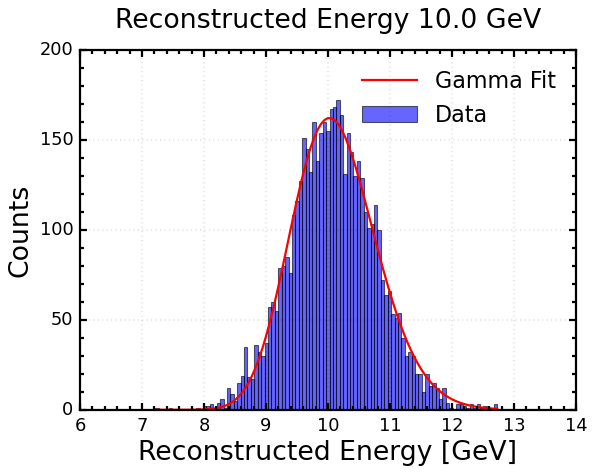

appending results for E = 10.0
Mean_Gamma: 10.1295453050518 Mean_Gamma_Error: 0.014599656945713642
Peak_Gamma: 10.024050161343197 Peak_Gamma_Error: 0.014454588361736983
Mean: 20.0928067905651, Peak: 20.047445958082392, RMS: 1.137463688564762
Initial Gamma Fit Parameters: [np.float64(524.6888755050642), np.float64(5.072860318156863), np.float64(14.322612381500582), np.float64(1.137463688564762)]
Gamma Fit Bounds: lower [np.float64(5.246888755050642), np.float64(-0.4927139681843137), np.float64(0.43226123815005835), np.float64(0.11374636885647621)], 
 upper [np.float64(3148.1332530303853), np.float64(50.72860318156863), np.float64(31.48391857225087), np.float64(11.37463688564762)]
Gamma Fit Parameters: [5.19677236e+02 5.07286032e+01 1.23271618e+01 1.54319604e-01]
Gamma Fit Peak: 20.001260088134778 ± 0.025669690328629858, Mean: 20.155579691868343 ± 0.025876632498985055, Resolution: 0.05495284661181183 ± 0.0008842195704470169


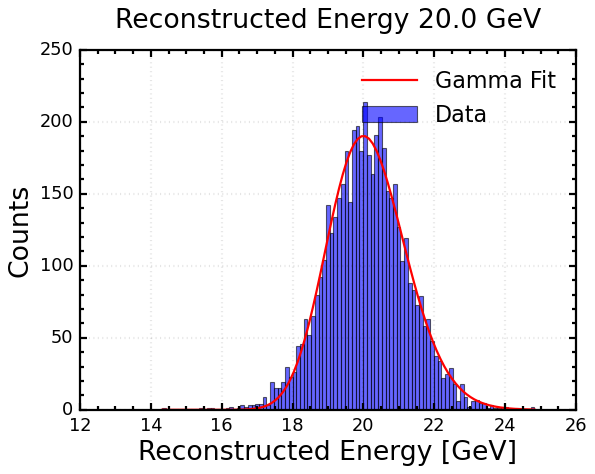

appending results for E = 20.0
Mean_Gamma: 20.155579691868343 Mean_Gamma_Error: 0.025876632498985055
Peak_Gamma: 20.001260088134778 Peak_Gamma_Error: 0.025669690328629858
Mean: 30.15331447313224, Peak: 30.395078768394846, RMS: 1.554593931604001
Initial Gamma Fit Parameters: [np.float64(611.0769060727537), np.float64(3.8161619404670453), np.float64(24.220732278464023), np.float64(1.554593931604001)]
Gamma Fit Bounds: lower [np.float64(6.110769060727537), np.float64(-0.6183838059532955), np.float64(1.4220732278464023), np.float64(0.1554593931604001)], 
 upper [np.float64(3666.461436436522), np.float64(38.16161940467045), np.float64(46.33109841769603), np.float64(15.545939316040009)]
Gamma Fit Parameters: [6.05764896e+02 3.81616194e+01 2.09015300e+01 2.46147701e-01]
Gamma Fit Peak: 30.04877712950522 ± 0.040368364661496466, Mean: 30.29492483044151 ± 0.04080566540914401, Resolution: 0.05060371243531908 ± 0.0009440863719364482


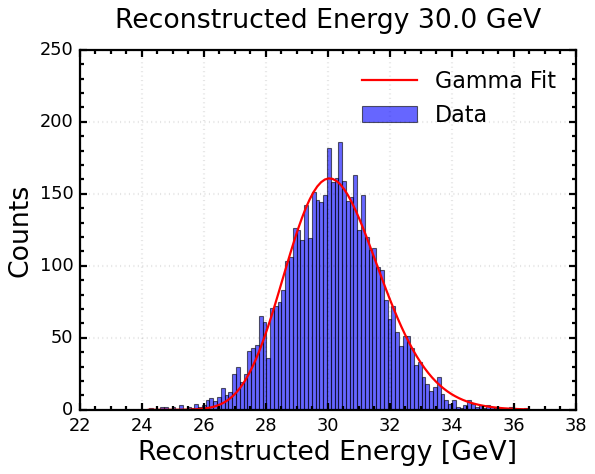

appending results for E = 30.0
Mean_Gamma: 30.29492483044151 Mean_Gamma_Error: 0.04080566540914401
Peak_Gamma: 30.04877712950522 Peak_Gamma_Error: 0.040368364661496466
Mean: 40.03883339017104, Peak: 39.83418496327106, RMS: 1.882742919344036
Initial Gamma Fit Parameters: [np.float64(796.2267465170003), np.float64(3.619534219873647), np.float64(33.224180966380494), np.float64(1.882742919344036)]
Gamma Fit Bounds: lower [np.float64(7.962267465170003), np.float64(-0.6380465780126352), np.float64(2.3224180966380494), np.float64(0.1882742919344036)], 
 upper [np.float64(4777.360479102002), np.float64(36.19534219873647), np.float64(59.836271449570745), np.float64(18.82742919344036)]
Gamma Fit Parameters: [7.84551824e+02 3.61953422e+01 2.93771657e+01 2.98277593e-01]
Gamma Fit Peak: 39.87514768617672 ± 0.04167891072508693, Mean: 40.173425279448146 ± 0.042151647541460675, Resolution: 0.04500333193963092 ± 0.0007361034250556668


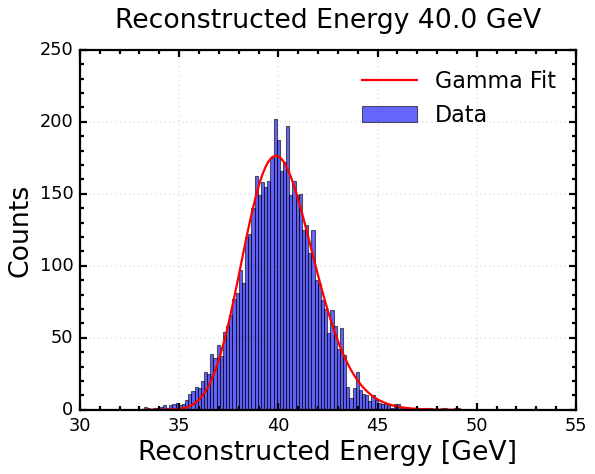

appending results for E = 40.0
Mean_Gamma: 40.173425279448146 Mean_Gamma_Error: 0.042151647541460675
Peak_Gamma: 39.87514768617672 Peak_Gamma_Error: 0.04167891072508693
Mean: 50.176949490173506, Peak: 50.32946969055797, RMS: 2.092226925962041
Initial Gamma Fit Parameters: [np.float64(962.1099029507106), np.float64(4.481435164746293), np.float64(40.800770171538176), np.float64(2.092226925962041)]
Gamma Fit Bounds: lower [np.float64(9.621099029507107), np.float64(-0.5518564835253706), np.float64(3.080077017153818), np.float64(0.2092226925962041)], 
 upper [np.float64(5772.659417704264), np.float64(44.814351647462935), np.float64(71.20115525730726), np.float64(20.92226925962041)]
Gamma Fit Parameters: [9.43401869e+02 4.48143516e+01 3.72281914e+01 2.90335000e-01]
Gamma Fit Peak: 49.94903114395268 ± 0.04125423855264168, Mean: 50.239366143635664 ± 0.0416299817676101, Resolution: 0.03891176075286341 ± 0.0005703290321439928


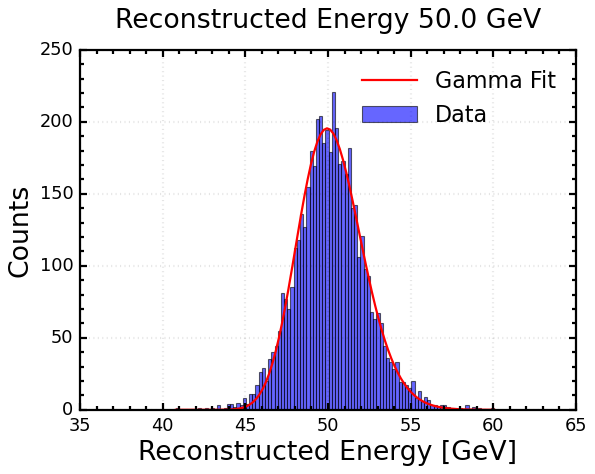

appending results for E = 50.0
Mean_Gamma: 50.239366143635664 Mean_Gamma_Error: 0.0416299817676101
Peak_Gamma: 49.94903114395268 Peak_Gamma_Error: 0.04125423855264168
Mean: 60.18264891517276, Peak: 59.17670060298963, RMS: 2.4251152813572916
Initial Gamma Fit Parameters: [np.float64(886.0984601659853), np.float64(3.961867330187422), np.float64(50.57466391002503), np.float64(2.4251152813572916)]
Gamma Fit Bounds: lower [np.float64(8.860984601659853), np.float64(-0.6038132669812577), np.float64(4.057466391002503), np.float64(0.24251152813572918)], 
 upper [np.float64(5316.590760995912), np.float64(39.618673301874225), np.float64(85.86199586503754), np.float64(24.251152813572915)]
Gamma Fit Parameters: [8.88424151e+02 3.96186733e+01 4.47604080e+01 3.90833656e-01]
Gamma Fit Peak: 59.853885292253054 ± 0.0413793100529658, Mean: 60.24471894838862 ± 0.04189110781735075, Resolution: 0.04110073350156367 ± 0.0004829529723201509


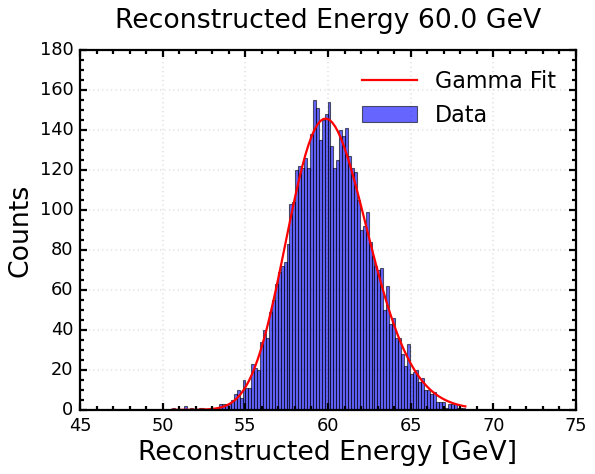

appending results for E = 60.0
Mean_Gamma: 60.24471894838862 Mean_Gamma_Error: 0.04189110781735075
Peak_Gamma: 59.853885292253054 Peak_Gamma_Error: 0.0413793100529658


In [5]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error,
            "Best_Val_Loss": best_val_loss
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_{CONF_NAME}_Fit.csv")
print(f"Saving fit results to {outputfile_name}")
OutputCSV(Reco_hist_calib, Energy_test, outputfile_name)